In [56]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense
from nltk.stem import PorterStemmer

In [27]:
# Specify column names
column_names = ['Review', 'Label']

# Read in txt files and set column headers
amazon = pd.read_csv('amazon_cells_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'Amazon shape: {amazon.shape}')
imdb = pd.read_csv('imdb_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'IMDB shape: {imdb.shape}')
yelp = pd.read_csv('yelp_labelled.txt', delimiter='\t', header=None, names=column_names)
print(f'Yelp shape: {yelp.shape}')

Amazon shape: (1000, 2)
IMDB shape: (748, 2)
Yelp shape: (1000, 2)


In [38]:
# Concatenate the three dataframes together
df = pd.concat([amazon, imdb, yelp], ignore_index=True)

In [39]:
# Check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  2748 non-null   object
 1   Label   2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 43.1+ KB


In [40]:
# Check Label to make sure values look appropriate
df['Label'].value_counts(dropna=False)

Label
1    1386
0    1362
Name: count, dtype: int64

# Applying Lowercase and Remove Punctuation

In [41]:
# Using Regex to search for special characters (Python, 2024)
# Regex pattern for special characters excluding punctuation
pattern = r'[^A-Za-z0-9\s\.,!?;:\-\'\"()]'

# Search using Regex pattern
mask = df['Review'].str.contains(pattern, regex=True)

# Filter using mask to show rows with special characters
special_char_rows = df[mask]
special_char_rows

,Review,Label
12,If the two were seperated by a mere 5+ ft I st...,0
25,Great Pocket PC / phone combination.,1
132,Headset works great & was packaged nicely to a...,1
154,I've bought $5 wired headphones that sound bet...,0
156,"Nice quality build, unlike some cheap s*** out...",1
...,...,...
2626,"I love the owner/chef, his one authentic Japan...",1
2663,The only thing I wasn't too crazy about was th...,0
2684,The sangria was about half of a glass wine ful...,0
2733,The problem I have is that they charge $11.99 ...,0


In [42]:
print('Before any preprocessing:')
print(df['Review'].iloc[12])
print()

# Set 'Review' to lowercase
df['Review'] = df['Review'].str.lower()

print('After applying lowercase:')
print(df['Review'].iloc[12])
print()

# Remove special characters and punctuation (Python, 2024)
pattern = r'[^\w\s]'
df['Review'] = df['Review'].str.replace(pattern, '', regex=True)

print('After removing punctuation:')
print(df['Review'].iloc[12])

Before any preprocessing:
If the two were seperated by a mere 5+ ft I started to notice excessive static and garbled sound from the headset.

After applying lowercase:
if the two were seperated by a mere 5+ ft i started to notice excessive static and garbled sound from the headset.

After removing punctuation:
if the two were seperated by a mere 5 ft i started to notice excessive static and garbled sound from the headset


# Tokenization and Stop words

In [43]:
# Apply Tokenization and remove stop words (Sewell, Web6)

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


print('Before tokenizing and applying stopwords:')
print(df['Review'].iloc[12])
print()

# Download stop word list
stop_words = set(stopwords.words('english'))

# Create empty list
data_set = []

# Tokenize and remove stop words
for sentence in df['Review']:
    data_set.append([word for word in word_tokenize(sentence) if word not in stop_words])

# Assign list back to dataframe
df['Review'] = data_set

print('After tokenizing and applying stopwords:')
print(df['Review'].iloc[12])

Before tokenizing and applying stopwords:
if the two were seperated by a mere 5 ft i started to notice excessive static and garbled sound from the headset

After tokenizing and applying stopwords:
['two', 'seperated', 'mere', '5', 'ft', 'started', 'notice', 'excessive', 'static', 'garbled', 'sound', 'headset']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Apply Stemming

In [44]:
# Apply Stemming (GeeksforGeeks, 2023)

print('Before Stemming:')
print(df['Review'].iloc[12])
print()

# Initialize PorterStemmer object
stemmer = PorterStemmer()

# Create a function to stem tokenized text
def stem_tokens(token_list):
    return [stemmer.stem(word) for word in token_list]

# Apply the function
df['Review'] = df['Review'].apply(stem_tokens)

print('After Stemming:')
print(df['Review'].iloc[12])

Before Stemming:
['two', 'seperated', 'mere', '5', 'ft', 'started', 'notice', 'excessive', 'static', 'garbled', 'sound', 'headset']

After Stemming:
['two', 'seper', 'mere', '5', 'ft', 'start', 'notic', 'excess', 'static', 'garbl', 'sound', 'headset']


# Determine Vocabulary Size and Vectorization

In [51]:
# Vectorization (Sewell, Web6)
print('Before vectorizing for model:')
print(df['Review'].iloc[12])
print()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])

print('After vectorizing for model:')
print(sequences[12])
print()

Before vectorizing for model:
['two', 'seper', 'mere', '5', 'ft', 'start', 'notic', 'excess', 'static', 'garbl', 'sound', 'headset']

After vectorizing for model:
[75, 1261, 1844, 231, 1845, 187, 763, 1262, 970, 1846, 41, 40]



In [52]:
# Get the word index and word counts
word_index = tokenizer.word_index

# The vocabulary size is the length of the word_index
vocab_size = len(word_index)
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 4176


# Determine Max Length For Padding

count    2748.000000
mean        6.857715
std        20.398946
min         1.000000
25%         3.000000
50%         5.000000
75%         8.000000
max       789.000000
dtype: float64


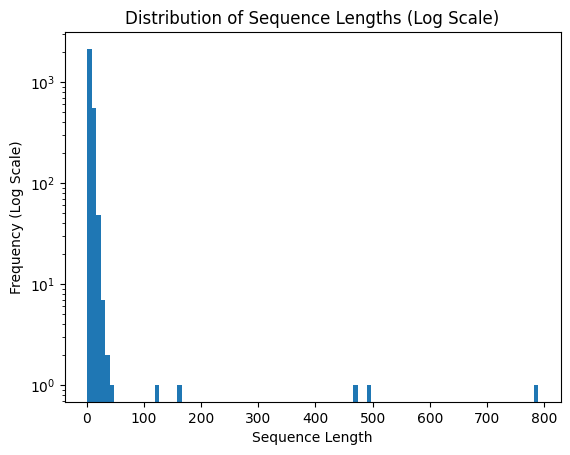

Chosen max_length: 14


In [60]:
# Calculate the lengths of the sequences
lengths = [len(seq) for seq in sequences]

# Describe the lengths
lengths_series = pd.Series(lengths)
print(lengths_series.describe())

# Plot the distribution of sequence lengths
plt.hist(lengths, bins=100, log=True)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency (Log Scale)')
plt.title('Distribution of Sequence Lengths (Log Scale)')
plt.show()

max_length = int(np.percentile(lengths, 95))
print(f'Chosen max_length: {max_length}')

# Apply Padding

In [14]:
# Pad Sequences (Sewell, Web6)
print('Before padding:')
print(sequences[0])
print()

X = pad_sequences(sequences, maxlen = max_length, padding='post')

print('After padding:')
print(X[0])

Before padding:
[52, 230, 120, 566, 17, 1839]

After padding:
[  52  230  120  566   17 1839    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0

# Implement Model

In [15]:
y = df['Label'].values

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Original shape: {df.shape}')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Original shape: (2748, 2)
(2198, 492)
(550, 492)
(2198,)
(550,)


In [17]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping


embedding_vector_length = 300
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.4922 - loss: 0.6965 - val_accuracy: 0.5068 - val_loss: 0.6952
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - accuracy: 0.5121 - loss: 0.6937 - val_accuracy: 0.5068 - val_loss: 0.6974
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.4958 - loss: 0.7023 - val_accuracy: 0.5068 - val_loss: 0.6939
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.5087 - loss: 0.6935 - val_accuracy: 0.4932 - val_loss: 0.6934
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.5027 - loss: 0.6938 - val_accuracy: 0.5091 - val_loss: 0.6931
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.4907 - loss: 0.6949 - val_accuracy: 0.4932 - val_loss: 0.6933
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.5127 - loss: 0.6931 - val_accuracy: 0.5068 - val_loss: 0.6942
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.5220 - loss: 0.6941 - val_accu

In [18]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

embedding_vector_length = 300
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(SpatialDropout1D(0.3))

# Adding more LSTM layers with bidirectional wrapping
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3)))

# Adding more dense layers with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

# Final output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

print()
print()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4952 - loss: 0.6957 - val_accuracy: 0.5273 - val_loss: 0.6925
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.5026 - loss: 0.6936 - val_accuracy: 0.5068 - val_loss: 0.6910
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.5253 - loss: 0.6920 - val_accuracy: 0.6000 - val_loss: 0.6889
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.5488 - loss: 0.6870 - val_accuracy: 0.5227 - val_loss: 0.6768
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.6403 - loss: 0.6578 - val_accuracy: 0.7568 - val_loss: 0.5405
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8177 - loss: 0.4597 - val_accuracy: 0.7750 - val_loss: 0.5152
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.8854 - loss: 0.3343 - val_accuracy: 0.7682 - val_loss: 0.4871
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.9351 - loss: 0.2250 - val_accuracy: 0.7568 - val_loss:

In [19]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

embedding_vector_length = 300
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=l2(0.01))))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

print()
print()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.4713 - loss: 12.8974 - val_accuracy: 0.5091 - val_loss: 12.2015
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5216 - loss: 12.2578 - val_accuracy: 0.5091 - val_loss: 11.6772
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4865 - loss: 11.7623 - val_accuracy: 0.5091 - val_loss: 11.1816
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.4952 - loss: 11.2466 - val_accuracy: 0.5091 - val_loss: 10.7161
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5138 - loss: 10.7871 - val_accuracy: 0.5091 - val_loss: 10.2786
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.4854 - loss: 10.3518 - val_accuracy: 0.5091 - val_loss: 9.8679
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.4892 - loss: 9.9267 - val_accuracy: 0.5091 - val_loss: 9.4824
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.5176 - loss: 9.5109 - val_accuracy: 0.5091 

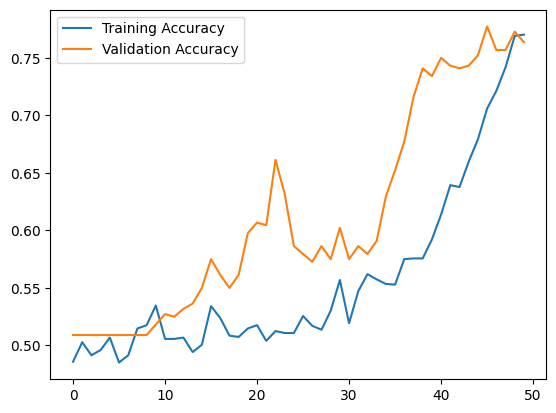

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

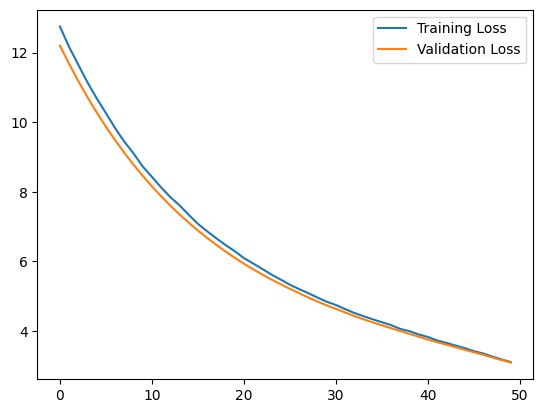

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [22]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 492, 300)            │         969,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 492, 300)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 492, 200)            │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 492, 200)            │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 100)                 │         100,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,201,433 (16.03 MB)

 Trainable params: 1,400,277 (5.34 MB)

 Non-trainable params: 600 (2.34 KB)

 Optimizer params: 2,800,556 (10.68 MB)

None


In [23]:
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping



# # Build the model with additional layers
# model = Sequential()
# model.add(Embedding(input_dim=50000, output_dim=128, input_length=max_length))
# model.add(LSTM(units=128, return_sequences=True))  # Return sequences to feed into the next LSTM layer
# model.add(LSTM(units=128))
# model.add(Dense(units=64, activation='relu'))  # Add a Dense layer with ReLU activation
# #model.add(Dropout(0.5))  # Add Dropout for regularization
# model.add(Dense(units=1, activation='sigmoid'))  # Use sigmoid activation for binary classification

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model with early stopping
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy}')